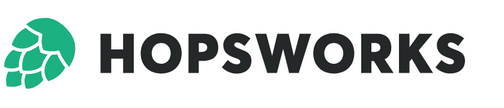


# Part 04: Model training & UI Exploration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_online/3_model_training.ipynb)

In this last notebook, you will train a model on the dataset you created in the previous tutorial. You will train the model using standard Python and Scikit-learn, although it could just as well be trained with other machine learning frameworks such as PySpark, TensorFlow, and PyTorch. You will also perform some of the exploration that can be done in Hopsworks, notably the search functions and the lineage.

## 🗒️ This notebook is divided in 3 main sections:

1. **Loading the training data**
2. **Train the model**
3. **Register model to Hopsworks model registry**.


In [ ]:
!pip install -U hopsworks --quiet

In [ ]:
!cd . & pip install -e .

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
feature_view = fs.get_feature_view("transactions_fraud_online_fv", 1)

## <span style="color:#ff5f27;"> ✨ Load Training Data </span>

First, you will need to fetch the training dataset that you created in the previous notebook. You will use January - February data training and testing.

In [4]:
import pandas as pd

train_mar_aug_x, train_mar_aug_y = feature_view.get_training_data(1)
test_sep_x, test_sep_y = feature_view.get_training_data(2)

In [5]:
train_mar_aug_x = train_mar_aug_x.sort_values(["cc_num", "datetime"])
train_mar_aug_y = train_mar_aug_y.reindex(train_mar_aug_x.index)

In [6]:
test_sep_x = test_sep_x.sort_values(["cc_num", "datetime"])
test_sep_y = test_sep_y.reindex(test_sep_x.index)

In [7]:
train_mar_aug_x.drop(["cc_num", "datetime"], axis = 1, inplace=True)
test_sep_x.drop(["cc_num","datetime"], axis = 1, inplace=True)

In [8]:
train_mar_aug_y.value_counts(normalize=True)

fraud_label
0              0.997695
1              0.002305
dtype: float64

Notice that the distribution is extremely skewed, which is natural considering that fraudulent transactions make up a tiny part of all transactions. Thus you should somehow address the class imbalance. There are many approaches for this, such as weighting the loss function, over- or undersampling, creating synthetic data, or modifying the decision threshold. In this example, you will use the simplest method which is to just supply a class weight parameter to our learning algorithm. The class weight will affect how much importance is attached to each class, which in our case means that higher importance will be placed on positive (fraudulent) samples.

## <span style="color:#ff5f27;"> 🏃 Train Model</span>

Next you will train a model. Here, you set larger class weight for the positive class.

In [9]:
!pip install -U xgboost --quiet

In [10]:
import numpy as np
import xgboost as xgb

clf = xgb.XGBClassifier()

clf.fit(train_mar_aug_x, train_mar_aug_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [11]:
# Train Predictions
y_pred_train = clf.predict(train_mar_aug_x)

In [12]:
# Test Predictions
y_pred_test = clf.predict(test_sep_x)

<AxesSubplot:>

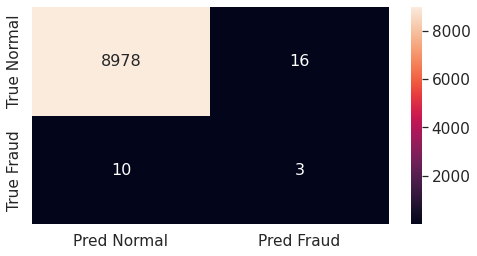

In [13]:
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot
import seaborn as sn

%matplotlib inline

if_cm=confusion_matrix(test_sep_y, y_pred_test)
df_cm = pd.DataFrame(if_cm, ['True Normal',  'True Fraud'],['Pred Normal', 'Pred Fraud'])

pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

<AxesSubplot:>

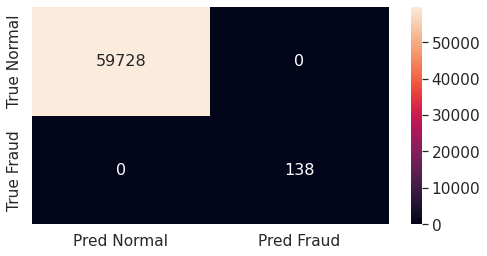

In [14]:
if_cm=confusion_matrix(train_mar_aug_y, y_pred_train)
pd.DataFrame(if_cm)
df_cm = pd.DataFrame(if_cm, ['True Normal',  'True Fraud'],['Pred Normal', 'Pred Fraud'])

pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [15]:
from sklearn.metrics import f1_score
# Compute f1 score
metrics = {"fscore": f1_score(test_sep_y, y_pred_test, average='micro')}
metrics

{'fscore': 0.9971133562784501}


## <span style="color:#ff5f27;"> Register model</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [16]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [17]:
import joblib
joblib.dump(clf, 'xgboost.pkl')

['xgboost.pkl']

The model needs to be set up with a Model Schema, which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [18]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(train_mar_aug_x)
output_schema = Schema(train_mar_aug_y)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

test_example = [0,
  0.0019420383761942894,
  97,
  0,
  0.572193529636784,
  0.19516419635385926,
  0.5750876539385888,
  -603.0627802609404,
  0.0,
  -0.00038772659880326866,
  -0.00038772659880326866,
  -3.7737138735312675e-05,
  1]

In [19]:
metrics

{'fscore': 0.9971133562784501}

In [20]:
model = mr.python.create_model(
    name="transactions_fraud_online_xgboost",
    metrics=metrics,
    description="xgboost anomaly detection model",
    input_example = test_example,
    model_schema=model_schema
)

model.save('xgboost.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/398/models/transactions_fraud_online_xgboost/1


Model(name: 'transactions_fraud_online_xgboost', version: 1)